In [1]:
import pathlib

from brokenaxes import brokenaxes
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
cd /home/pimienta/Documents/repos/coding/vocalpy/scipy-proceedings-2023-vak

/home/pimienta/Documents/repos/coding/vocalpy/scipy-proceedings-2023-vak


In [3]:
def munge_df(df):  
    df['avg_err'] = (1.0 - df['avg_val_acc']) * 100
    df['avg_err_tfm'] = (1.0 - df['avg_val_acc_tfm']) * 100
    df['avg_segment_error_rate'] = df['avg_val_segment_error_rate'] * 100
    df['avg_segment_error_rate_tfm'] = df['avg_val_segment_error_rate_tfm'] * 100

    df_out = []

    for value_vars, value_name in zip(
        (
            ['avg_segment_error_rate', 'avg_segment_error_rate_tfm'],
            ['avg_err', 'avg_err_tfm'],
        ),
        (
            'Syllable Error Rate', 'Frame Error',
        )
        
    ):
        melted = pd.melt(df, id_vars=['train_dur', 'replicate_num', 'model_name'],
                         value_vars=value_vars,
                         var_name='postprocess',
                         value_name=value_name,
                        )
        post_process_map = dict(zip(value_vars, (False, True)))
        melted['postprocess'] = melted['postprocess'].map(post_process_map)
        df_out.append(melted)

    df_out = pd.merge(*df_out)
    return df_out

In [4]:
RESULTS_ROOT = pathlib.Path('./results/BFSongRepo')

In [5]:
BIRD_IDS = [
    'bl26lb16',
    'gy6or6',
    'gr41rd51',
    'or60yw70',
]

NET_NAMES = [
    'TweetyNet',
    'TweetyNoLSTMNet',
]

In [6]:
data = []
for bird_id in BIRD_IDS:
    bird_root = RESULTS_ROOT / bird_id
    for net_name in NET_NAMES:
        net_root = bird_root / net_name
        results_dir = sorted(net_root.glob('results_*'))
        assert len(results_dir) == 1, f"results dir: {results_dir}"
        results_dir = results_dir[0]
        csv_path = results_dir / 'learning_curve.csv'
        df = pd.read_csv(csv_path)
        df = munge_df(df)
        df['net_name'] = net_name
        df['bird_id'] = bird_id
        data.append(df)

data = pd.concat(data)

In [7]:
NET_NAMES_RESULTS_DIR_MAP = {
    'TweetyNet': 'results/BFSongRepo/all-birds/TweetyNet/results_230628_144709',
    #'ED-TCN': 'results/BFSongRepo/all-birds/ED_TCN/results_230628_144655',
    'TweetyNoLSTMNet': 'results/BFSongRepo/all-birds/TweetyNoLSTMNet/results_230705_120958'
}

data_allbirds = []
for net_name, results_dir in NET_NAMES_RESULTS_DIR_MAP.items():
    results_dir = pathlib.Path(results_dir)
    csv_path = results_dir / 'learning_curve.csv'
    df = pd.read_csv(csv_path)
    # df = df.rename(columns={'train_dur': 'train_set_dur'})
    df = munge_df(df)
    # df.net_name = net_name
    data_allbirds.append(df)

data_allbirds = pd.concat(data_allbirds)

In [8]:
data_plot = data.copy()
data_plot['model_name'] = data_plot['model_name'].map(
    {'TweetyNet': 'TweetyNet', 'TweetyNoLSTMNet': 'TweetyNet (No LSTM)'}
)
data_plot['postprocess'] = data_plot['postprocess'].map({True: 'Yes', False: 'No'})
data_plot = data_plot.rename(columns={'postprocess': 'Post-processing'})

data_allbirds_plot = data_allbirds.copy()
data_allbirds_plot['model_name'] = data_allbirds_plot['model_name'].map(
    {'TweetyNet': 'TweetyNet', 'TweetyNoLSTMNet': 'TweetyNet (No LSTM)'}
)
data_allbirds_plot['postprocess'] = data_allbirds_plot['postprocess'].map({True: 'Yes', False: 'No'})
data_allbirds_plot = data_allbirds_plot.rename(columns={'postprocess': 'Post-processing'})


In [9]:
sns.set()
sns.set_context('talk')

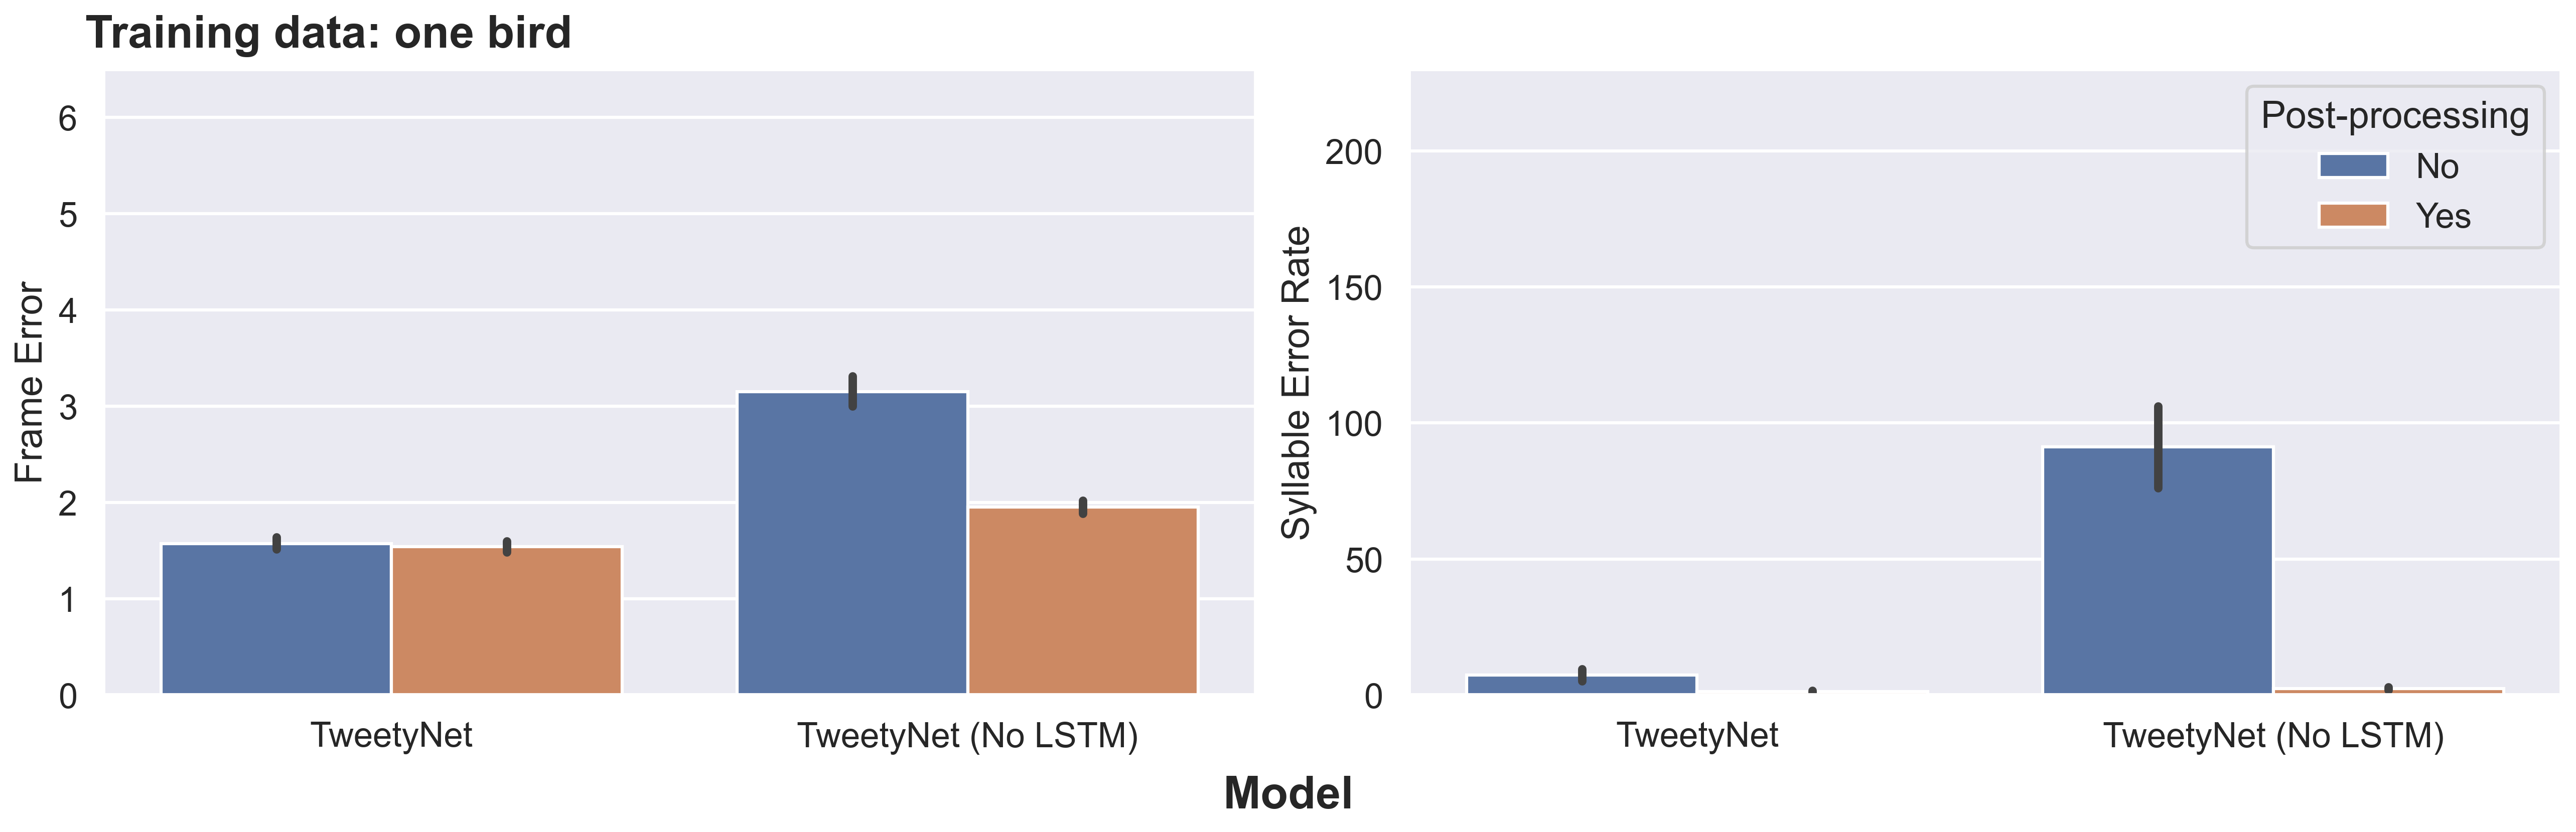

In [10]:
# fig, ax_arr = plt.subplots(2, 2, figsize=(15, 10), dpi=300)
fig = plt.figure(layout='constrained', figsize=(17, 5), dpi=300)
ax_arr = fig.subplots(1, 2)

for subfig_ind, (data_df, subfig_suptitle) in enumerate(
    zip(
        (data_plot,),
        ('Training data: one bird',)
    )
):
    data_plot_ = data_df[data_df.train_dur == 600]
    data_plot_ = data_plot_.rename(columns={'train_dur': 'Training Set Duration'})
    
    for ax_ind, (err_name, ylim) in enumerate(
        zip(
            ('Frame Error', 'Syllable Error Rate'),
            ([0., 6.5], [0., 230.])
        )
    ):
        ax = ax_arr[ax_ind]
        g = sns.barplot(
            data=data_plot_,
            y=err_name,
            x='model_name',
            hue='Post-processing',
            ax=ax,
        )
        ax.set_ylim(ylim)
        ax.set_xlabel('')

    fig.suptitle(subfig_suptitle, ha='left', x=0.03, weight='bold')

fig.supxlabel('Model', y=-0.075, weight='bold')
ax_arr[0].legend().remove()

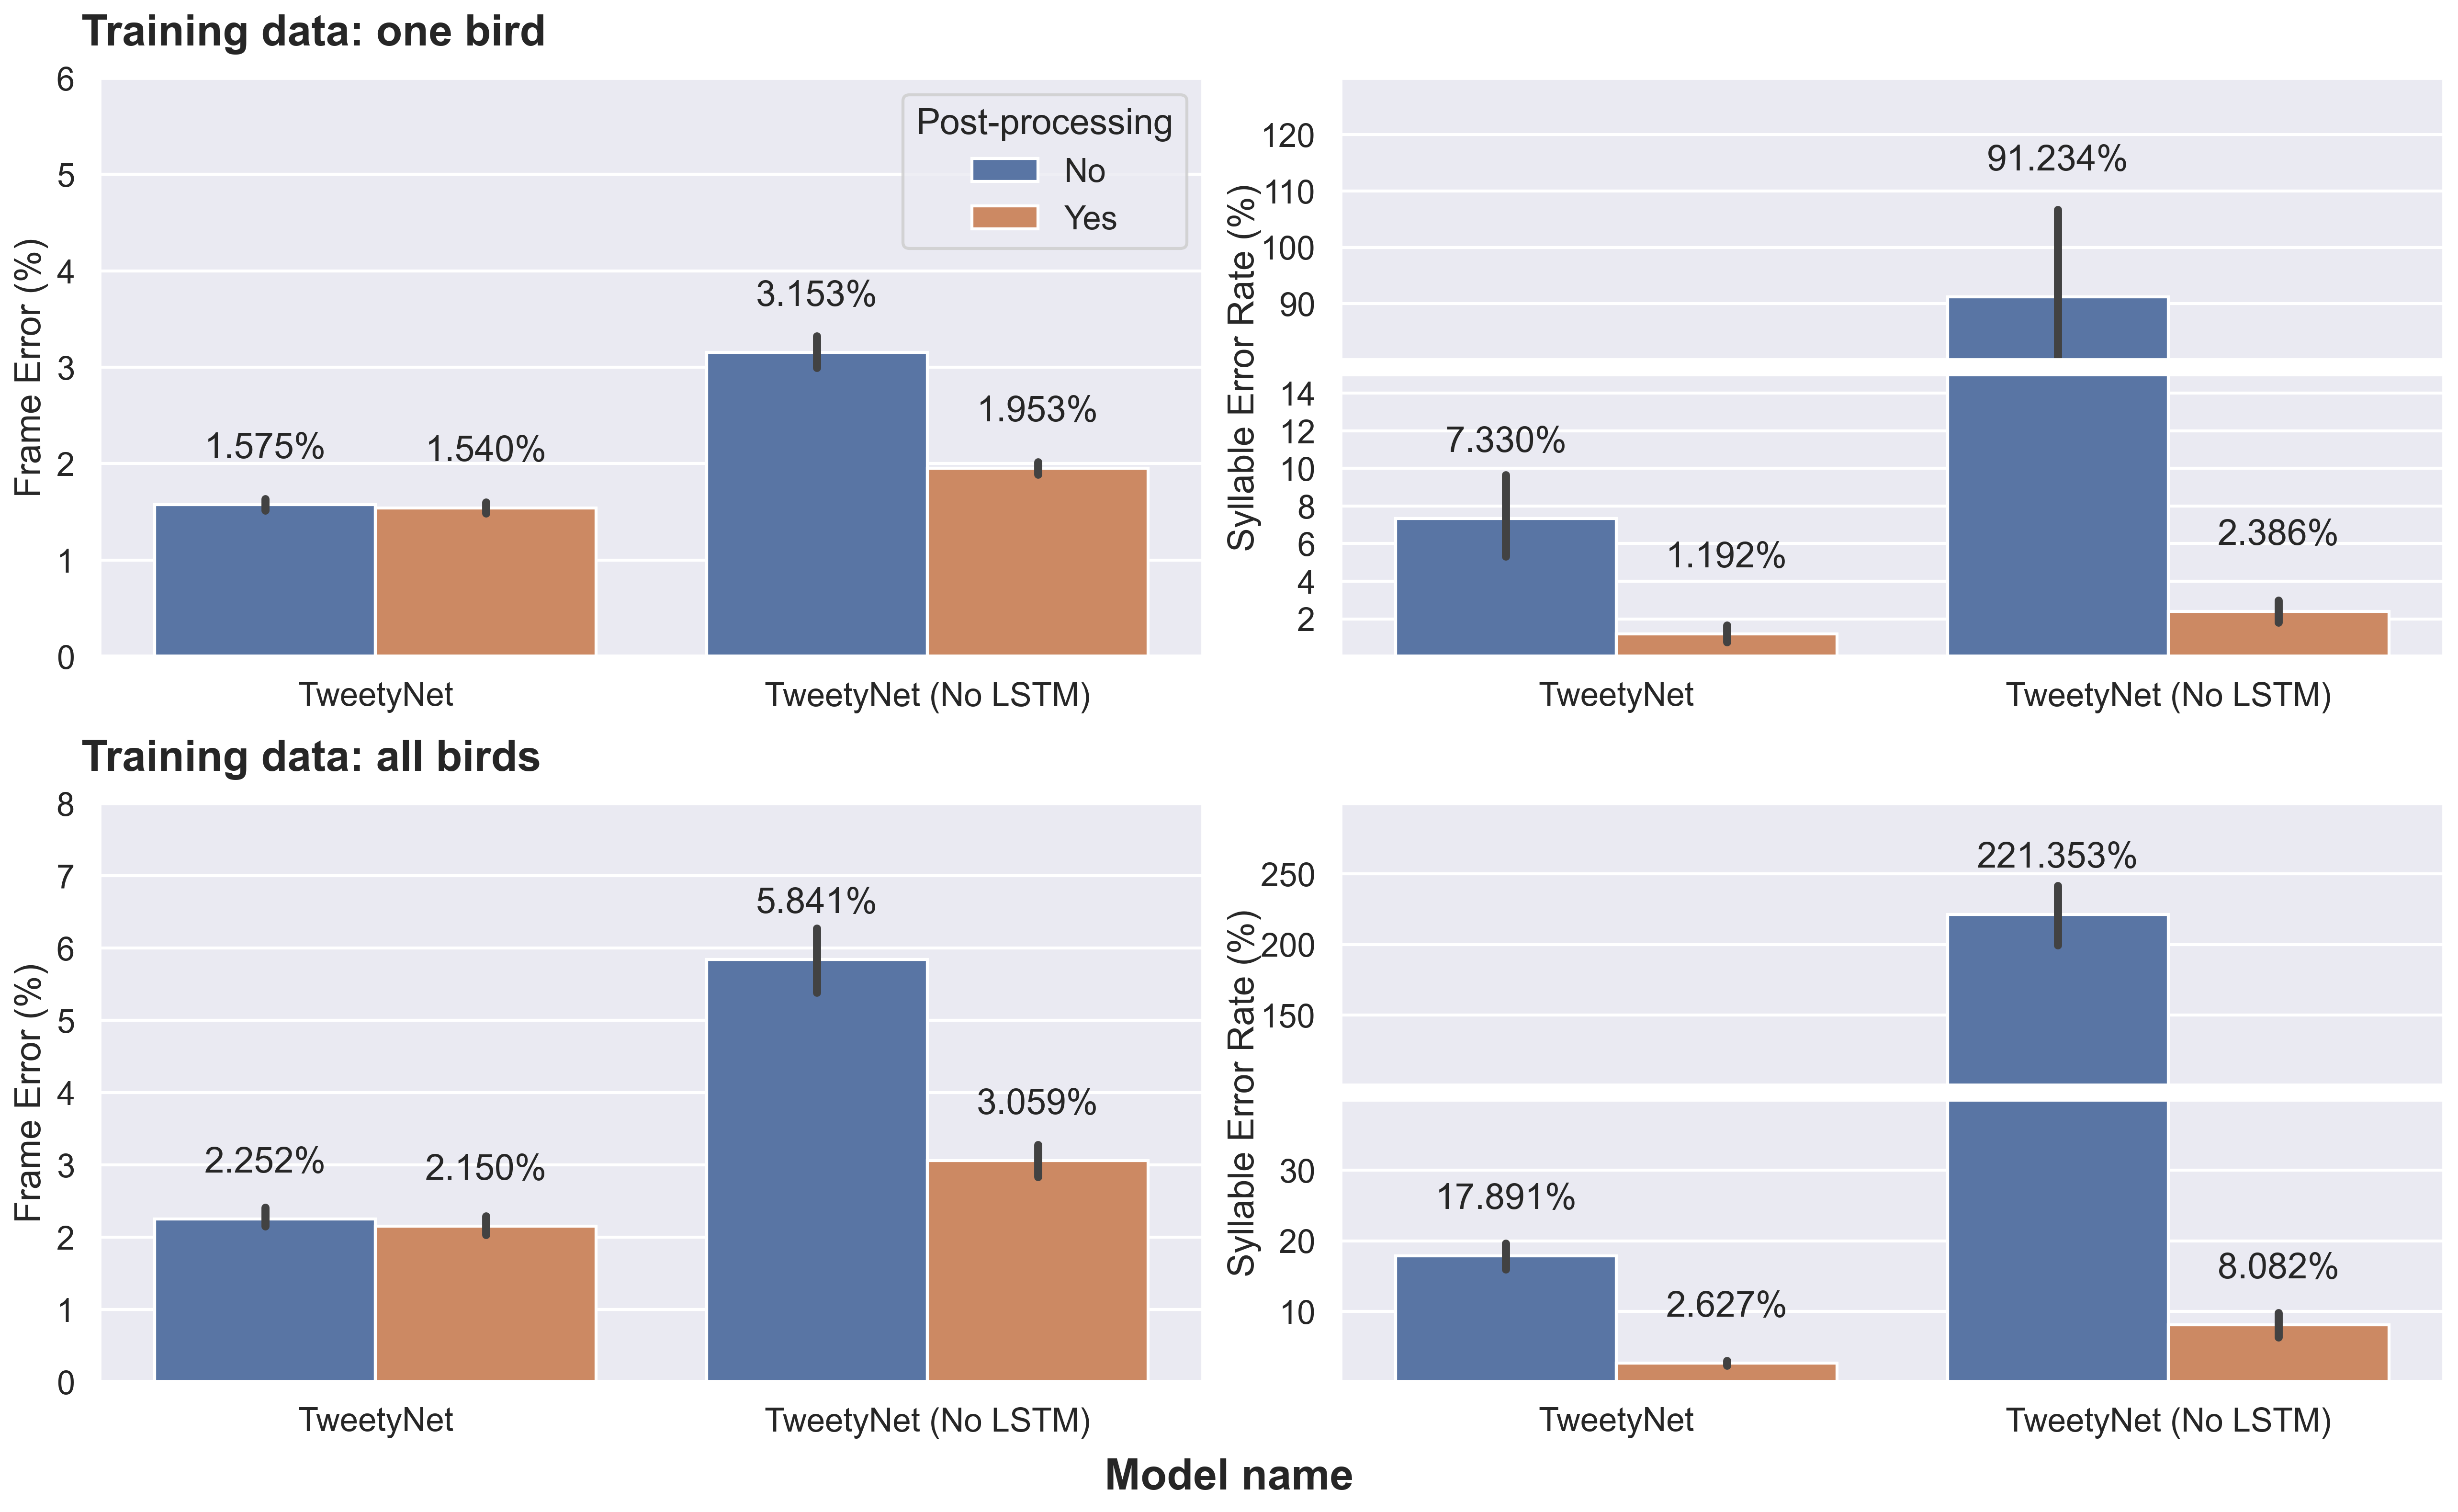

In [11]:
# fig, ax_arr = plt.subplots(2, 2, figsize=(15, 10), dpi=300)
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(layout='constrained', figsize=(17, 10), dpi=300)
subfigs = fig.subfigures(2, 1)

for subfig_ind, (data_df, subfig_suptitle, ylims, paddings, yticks) in enumerate(
    zip(
        (data_plot, data_allbirds_plot),
        ('Training data: one bird', 'Training data: all birds'),
        (
            ([0., 6], ([0., 15.], [80., 130.])),
            ([0., 8], ([0., 40.], [100., 300.])),
        ),
        (
            (20, 30, 60),
            (20, 20, 20),
        ),
        (
            ([2, 4, 6, 8, 10, 12, 14], [90, 100, 110, 120]),
            ([10, 20, 30], [150, 200, 250]),
        )
    )
):
    data_plot_ = data_df[data_df.train_dur == 600]
    data_plot_ = data_plot_.rename(columns={'train_dur': 'Training Set Duration'})

    subfig = subfigs[subfig_ind]
    ax_arr = subfig.subplots(1, 2)
    ax_to_break = ax_arr[1]
    divider = make_axes_locatable(ax_to_break)
    ax2 = divider.new_vertical(size="100%", pad=0.1)
    subfig.add_axes(ax2)
    
    for ax_ind, (err_name, ylim) in enumerate(
        zip(
            ('Frame Error', 'Syllable Error Rate'),
            ylims
        )
    ):
        if ax_ind == 0:
            ax = ax_arr[ax_ind]
            g = sns.barplot(
                data=data_plot_,
                y=err_name,
                x='model_name',
                hue='Post-processing',
                ax=ax,
            )
            ax.set_ylim(ylim)
            ax.set_xlabel('')
            ax.set_ylabel(f'{err_name} (%)')
            for bars in ax.containers:
                ax.bar_label(bars, padding=paddings[0], fmt='{:.3f}%')
        elif ax_ind == 1:
            for ind, ax in enumerate((ax_arr[1], ax2)):
                g = sns.barplot(
                    data=data_plot_,
                    y=err_name,
                    x='model_name',
                    hue='Post-processing',
                    ax=ax,
                )
                ax.set_ylim(ylim[ind])
                ax.set_xlabel('')
                ax.set_yticks(yticks[ind])
                ax.set_ylabel('')
                if ind == 1:
                    ax.set_xticks([])
                for bars in ax.containers:
                    ax.bar_label(bars, padding=paddings[ind + 1], fmt='{:.3f}%')
            bigax = subfig.add_subplot(1, 2, 2, frameon=False)
            bigax.set_ylabel(f'{err_name} (%)')
            bigax.grid(False)
            bigax.set_xticks([])
            bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    subfig.suptitle(subfig_suptitle, ha='left', x=0.03, weight='bold')

    if subfig_ind == 0:
        for ax in (ax_arr[1], ax2):
            ax.legend().remove()
    else:
        for ax in (*ax_arr, ax2):
            ax.legend().remove()

subfig.supxlabel('Model name', y=-0.075, weight='bold');

plt.savefig('./doc/figs/ablation-experiment.png', bbox_inches='tight')
plt.savefig('../scipy_proceedings/papers/david_nicholson/ablation-experiment.png', bbox_inches='tight')